<a href="https://colab.research.google.com/github/ShekharGaikwadDS/Self-Driving-Car-using-Deep-Learning/blob/main/Self_Driving_Cat_Component_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown 1Y5OHRq4KPVZuvY2BnuUnsEXq9o_GuzBM

Downloading...
From: https://drive.google.com/uc?id=1Y5OHRq4KPVZuvY2BnuUnsEXq9o_GuzBM
To: /content/selfdriving cars data.zip
100% 946M/946M [00:26<00:00, 35.9MB/s]


In [2]:
!ls

 sample_data  'selfdriving cars data.zip'


In [3]:
!unzip -q '/content/selfdriving cars data.zip'

In [4]:
!ls 'selfdriving cars data'

images	labels_train.csv  labels_trainval.csv  labels_val.csv


In [5]:
from glob import glob

print("Sample Images: ")
glob('/content/selfdriving cars data/images/*jpg')[:5]

Sample Images: 


['/content/selfdriving cars data/images/1479501918205513887.jpg',
 '/content/selfdriving cars data/images/1478732010698897814.jpg',
 '/content/selfdriving cars data/images/1478732106470141171.jpg',
 '/content/selfdriving cars data/images/1479504085351390318.jpg',
 '/content/selfdriving cars data/images/1479503057782078943.jpg']

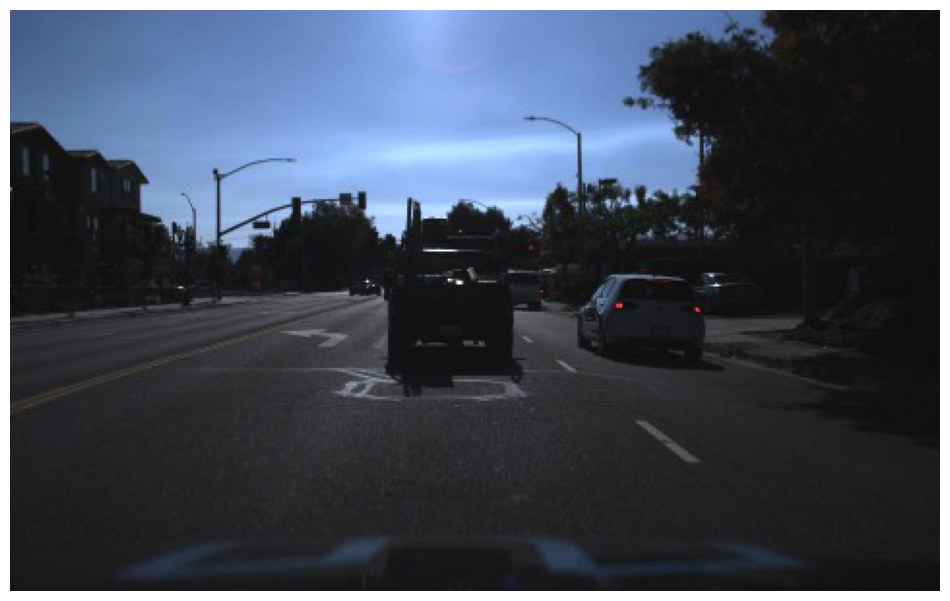

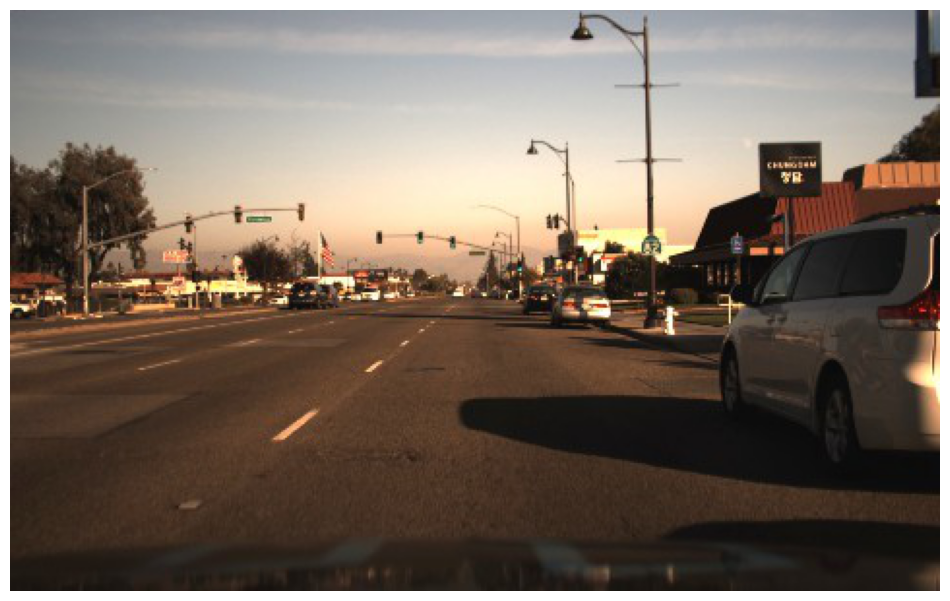

In [6]:
import matplotlib.pyplot as plt

for image_path in glob('/content/selfdriving cars data/images/*jpg')[:2]:
  plt.figure(figsize=(12,8))
  img = plt.imread(image_path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [7]:
!gdown 1g7BocB3bO9l3qk8pzBmn7F32A9ib3Tf2

Downloading...
From: https://drive.google.com/uc?id=1g7BocB3bO9l3qk8pzBmn7F32A9ib3Tf2
To: /content/YoloV5_ONNX.zip
100% 31.3M/31.3M [00:01<00:00, 23.1MB/s]


In [8]:
!unzip -q '/content/YoloV5_ONNX.zip'

In [9]:
ls

 coco.names.txt  'selfdriving cars data'/      YoloV5_ONNX.zip
 __MACOSX/       'selfdriving cars data.zip'   yolov5s.onnx
 sample_data/     yolov5n.onnx


In [10]:
# Load class names.
classesFile = "/content/coco.names.txt"
classes = None

with open(classesFile, 'rt') as f:
      classes = f.read().rstrip('\n').split('\n')

# print ID and value of classes in COCO
print(dict(enumerate(classes)))

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorbike', 4: 'aeroplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'sofa', 58: 'pottedplant', 59: 'bed', 60: 'diningtable', 61: 'toilet', 62: 'tvmonitor', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'mi

In [11]:
import cv2 
import numpy as np

# input image width and height
INPUT_WIDTH = 640
INPUT_HEIGHT = 640

# probability threshold to filter boxes with object or no object
OBJECT_SCORE_THRESHOLD = 0.5

# # probability threshold to detect and Assign Class
CLASS_CONFIDENCE_THRESHOLD = 0.45

# IOU AREA Threshold to suppress redundant boxes using NMS
NMS_THRESHOLD = 0.45

# Text parameters used for annotating label on Image
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.4
THICKNESS = 1
BOX_COLOR = (0,255,255)
FONT_COLOR= (0,0,0)


In [12]:
def draw_label(im, label, x, y):
    """Function used for Drawing text/label onto image at location."""

    # Get text size.
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]

    # Use text size to create a BLACK rectangle.
    cv2.rectangle(im, (x,y), (x + dim[0], y - (dim[1]+baseline) ), (255,255,255), cv2.FILLED);

    # Display text inside the rectangle.
    cv2.putText(im, label, (x, y - dim[1]+baseline ), FONT_FACE, FONT_SCALE, FONT_COLOR, THICKNESS, cv2.LINE_AA)

In [13]:
def yolo_forward_pass(input_image, net):
      """Performs forward pass to generate prediction using image and Loaded Yolo Model as parameters """
      # Create a 4D blob from a frame
      blob = cv2.dnn.blobFromImage(input_image, 1/255,  (INPUT_WIDTH, INPUT_HEIGHT), [0,0,0], 1, crop=False)

      # Sets the input to the network.
      net.setInput(blob)

      # Run the forward pass to get output of the output layers.
      outputs = net.forward(net.getUnconnectedOutLayersNames())

      return outputs 

In [14]:
def post_process_outputs(input_image, outputs):
     
      # Lists to hold respective values while unwrapping.
      class_ids = []
      confidences = []
      boxes = []

      # Rows
      rows = outputs[0].shape[1]
      image_height, image_width = input_image.shape[:2]

      # Resizing factor.
      x_factor = image_width / INPUT_WIDTH
      y_factor =  image_height / INPUT_HEIGHT

      # Iterate through detections.
      for r in range(rows):
            row = outputs[0][0][r]
            confidence = row[4]

            # Discard bad detections and continue.
            if confidence >= OBJECT_SCORE_THRESHOLD:
                  classes_scores = row[5:]

                  # Get the index of max class score.
                  class_id = np.argmax(classes_scores)

                  #  Continue if the class score is above threshold.
                  if (classes_scores[class_id] > CLASS_CONFIDENCE_THRESHOLD):
                        confidences.append(confidence)
                        class_ids.append(class_id)
                        cx, cy, w, h = row[0], row[1], row[2], row[3]

                        left = int((cx - w/2) * x_factor)
                        top = int((cy - h/2) * y_factor)
                        width = int(w * x_factor)
                        height = int(h * y_factor)

                        box = np.array([left, top, width, height])
                        boxes.append(box)
               
      # filter redundant Boxies using NMS Threshold                 
      indices = cv2.dnn.NMSBoxes(boxes, confidences, CLASS_CONFIDENCE_THRESHOLD, NMS_THRESHOLD)

      # plot remaining boxes
      for i in indices:
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]            

            # Draw bounding box.            
            cv2.rectangle(input_image, (left, top), (left + width, top + height), BOX_COLOR, 2*THICKNESS)

            # Class label.                     
            label = "{}:{:.2f}".format(classes[class_ids[i]], confidences[i])             

            # Draw label.            
            draw_label(input_image, label, left, top)

      return input_image


In [15]:
sample_images = ['/content/selfdriving cars data/images/1478732518231513348.jpg',
 '/content/selfdriving cars data/images/1478900224707428956.jpg',
 '/content/selfdriving cars data/images/1478898970726449449.jpg',
 '/content/selfdriving cars data/images/1478895374457789828.jpg',
 '/content/selfdriving cars data/images/1479504796899191419.jpg',
 '/content/selfdriving cars data/images/1479498467969466999.jpg']

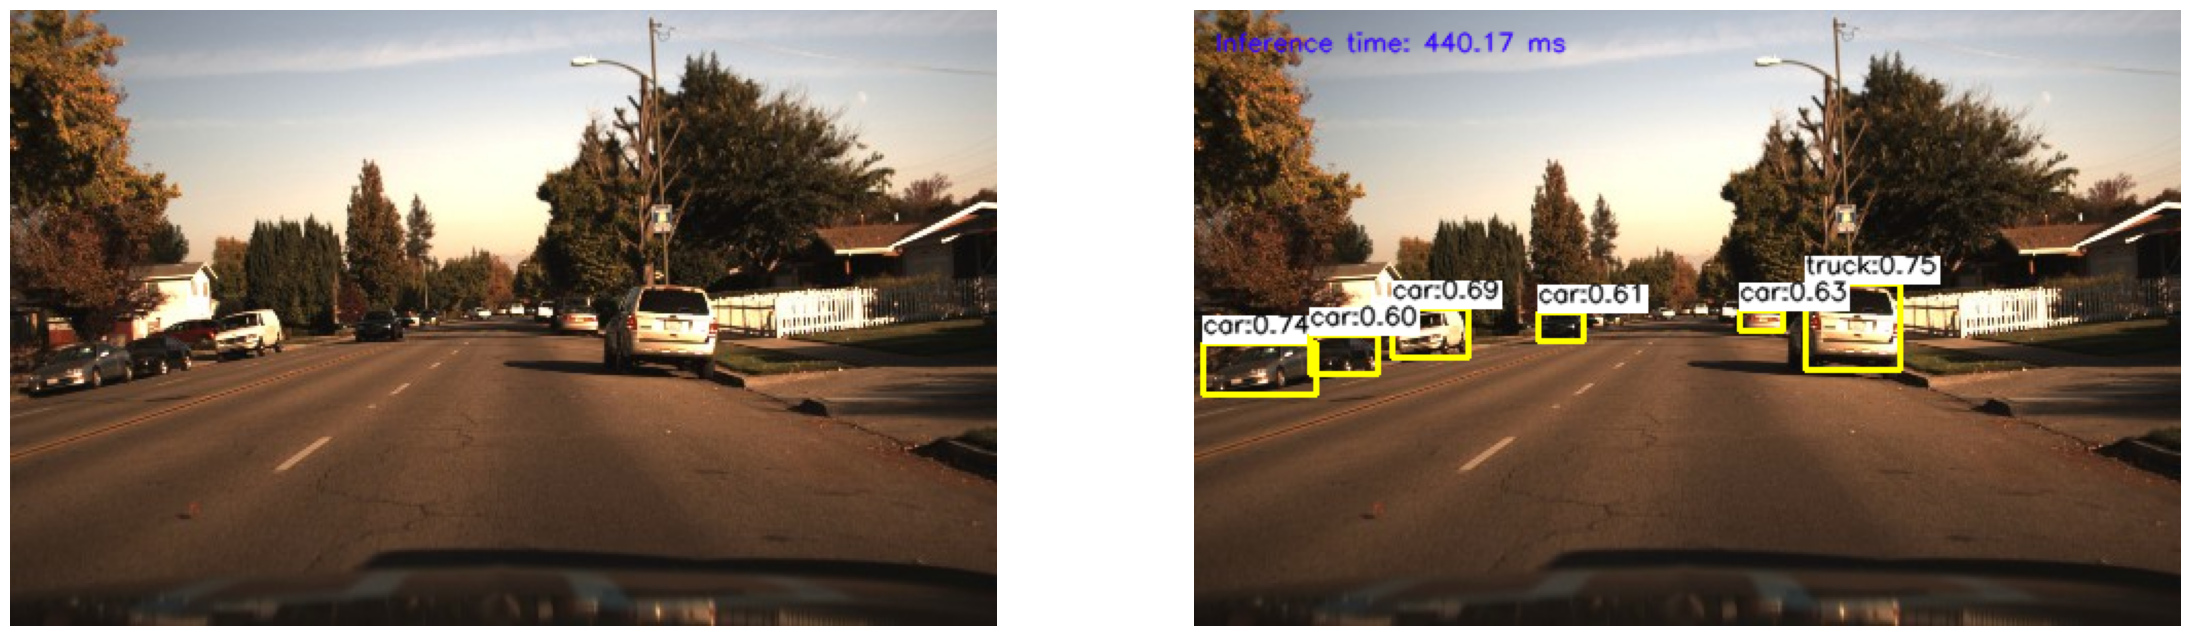

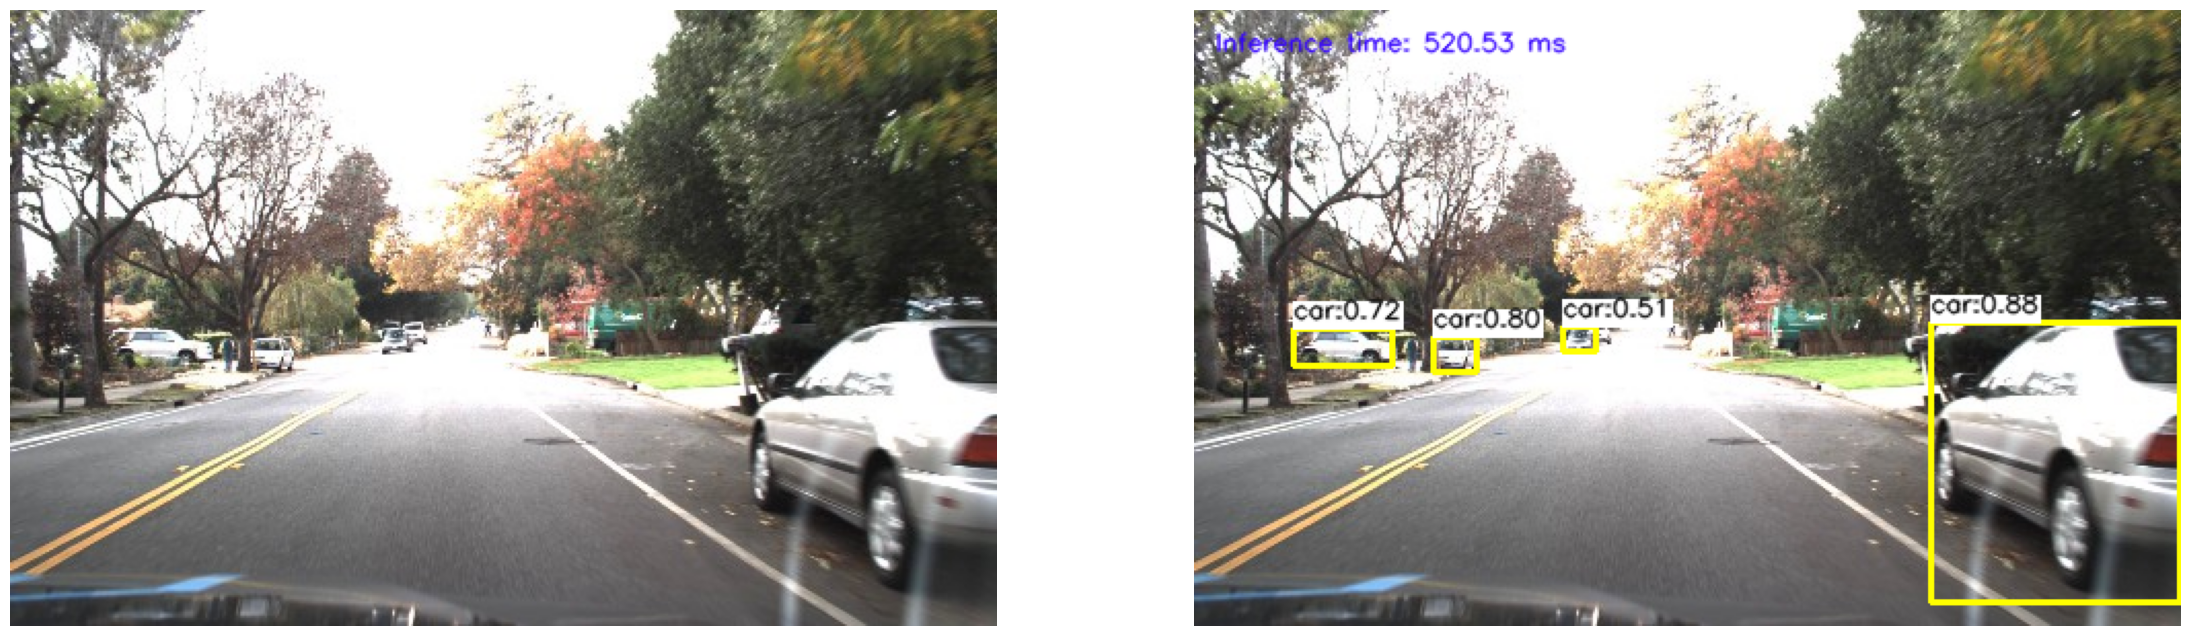

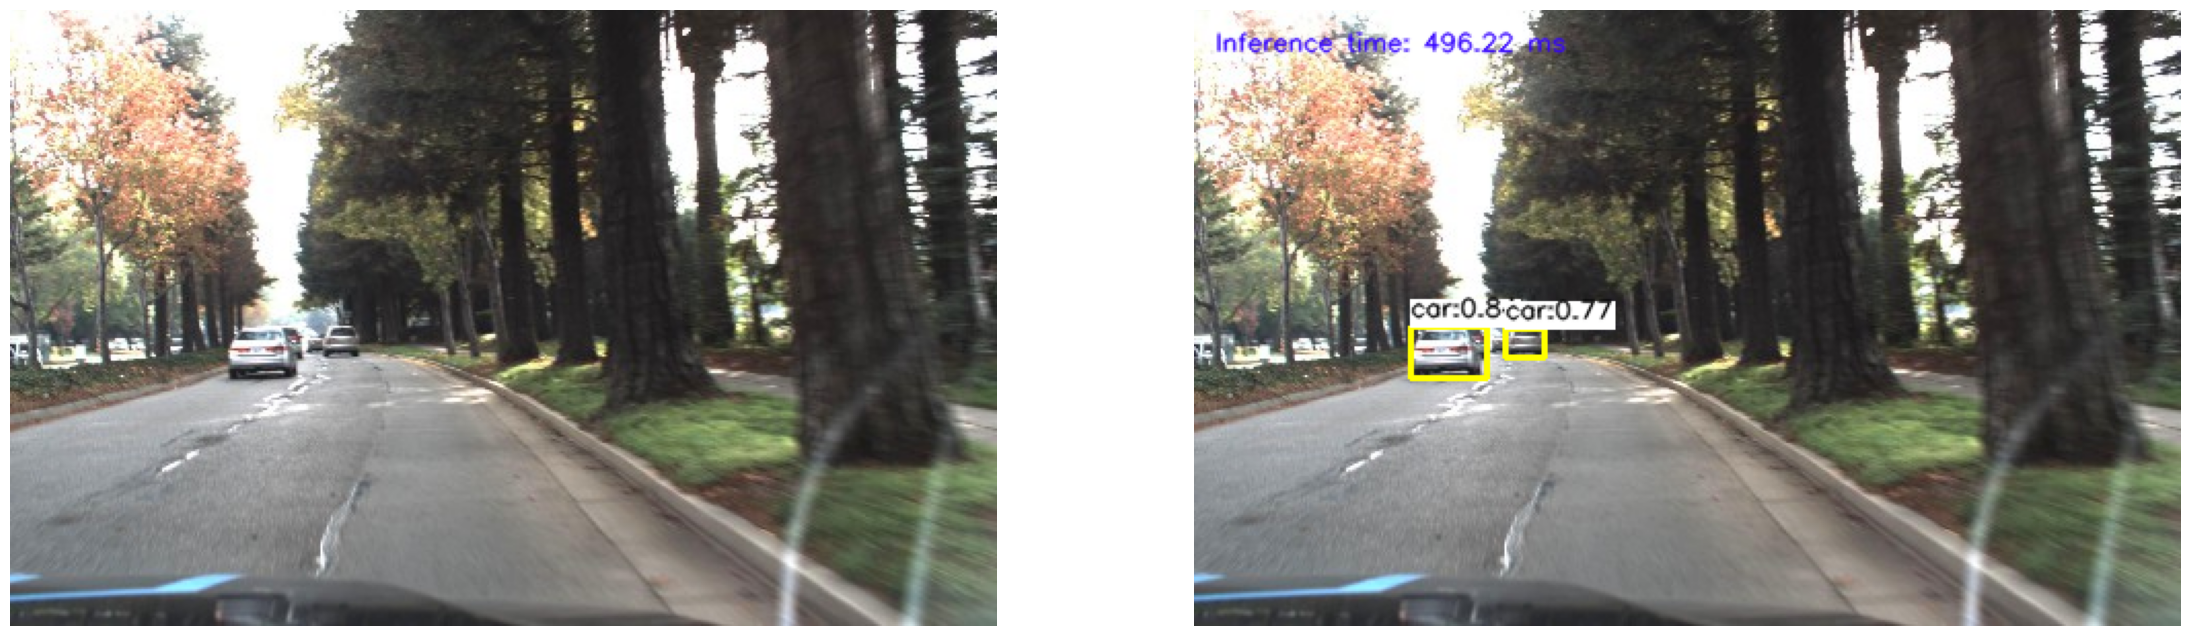

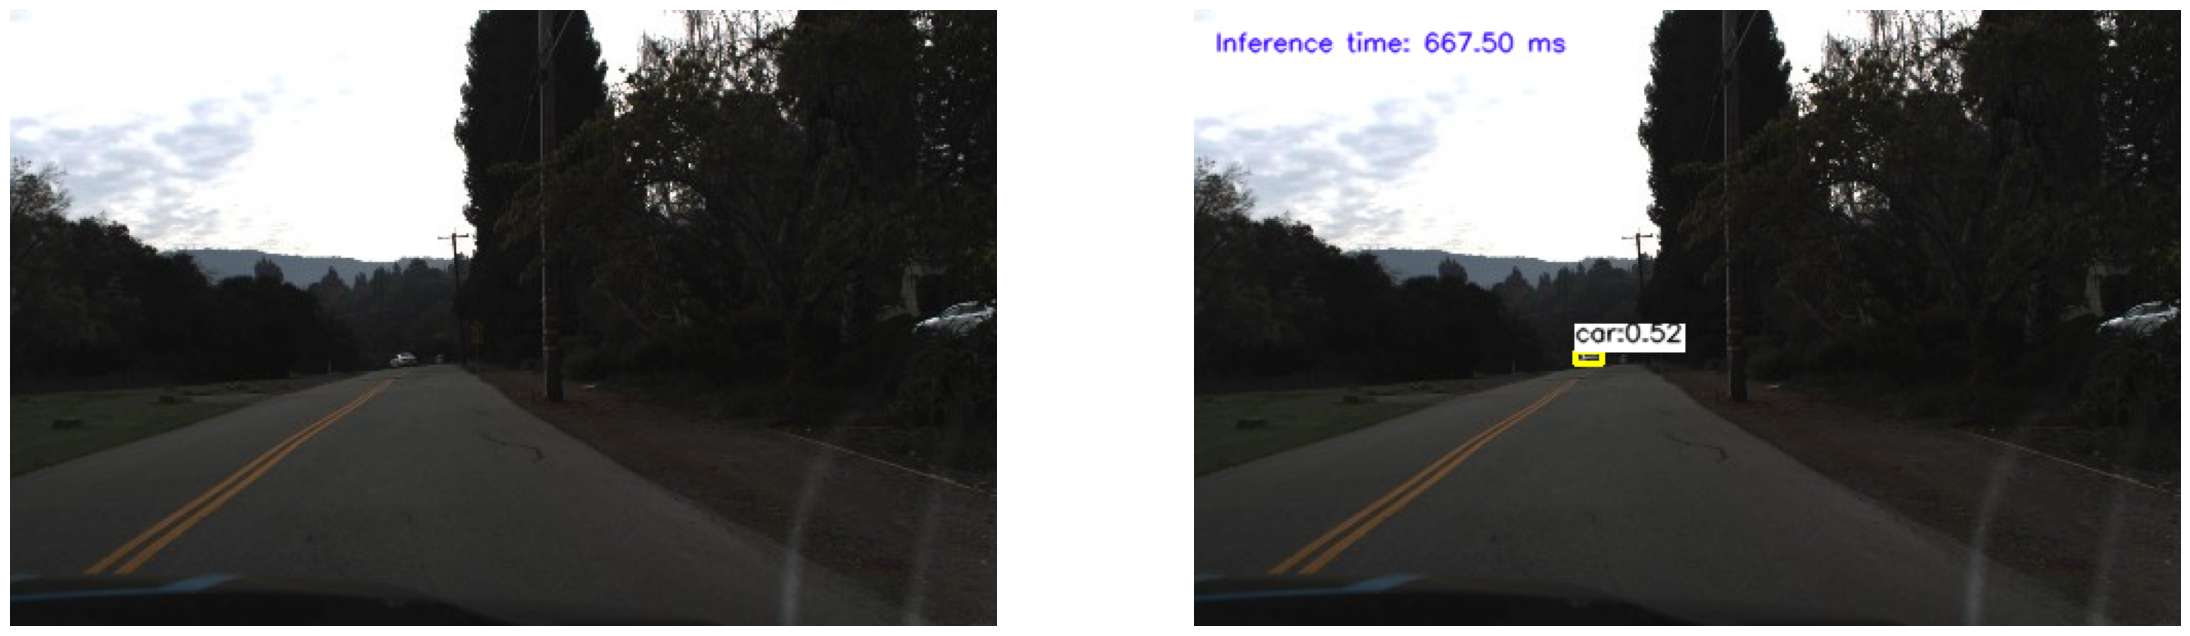

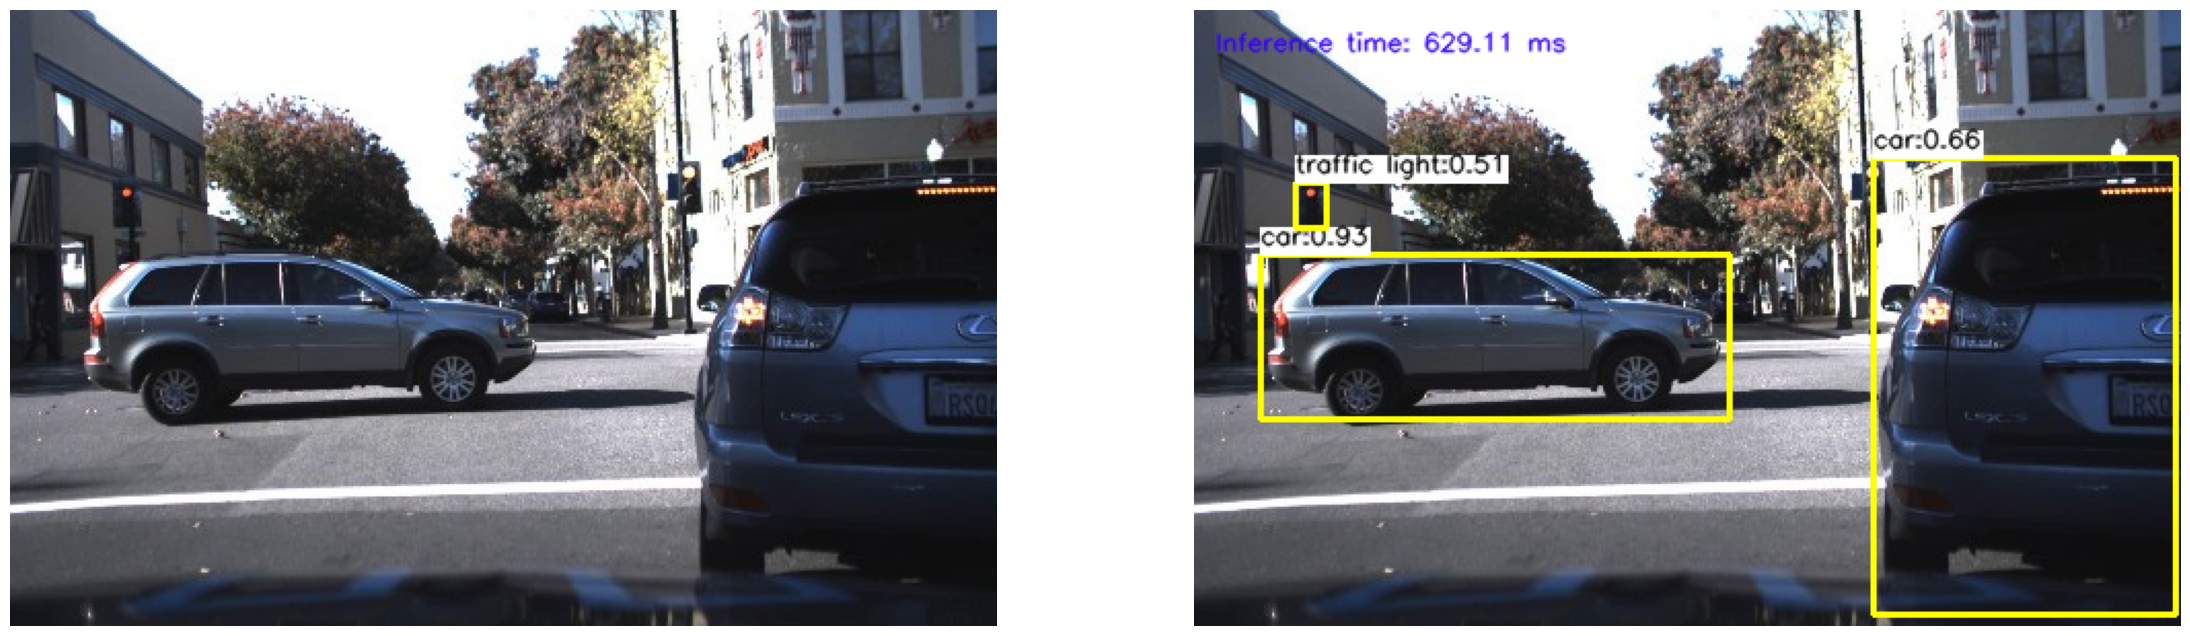

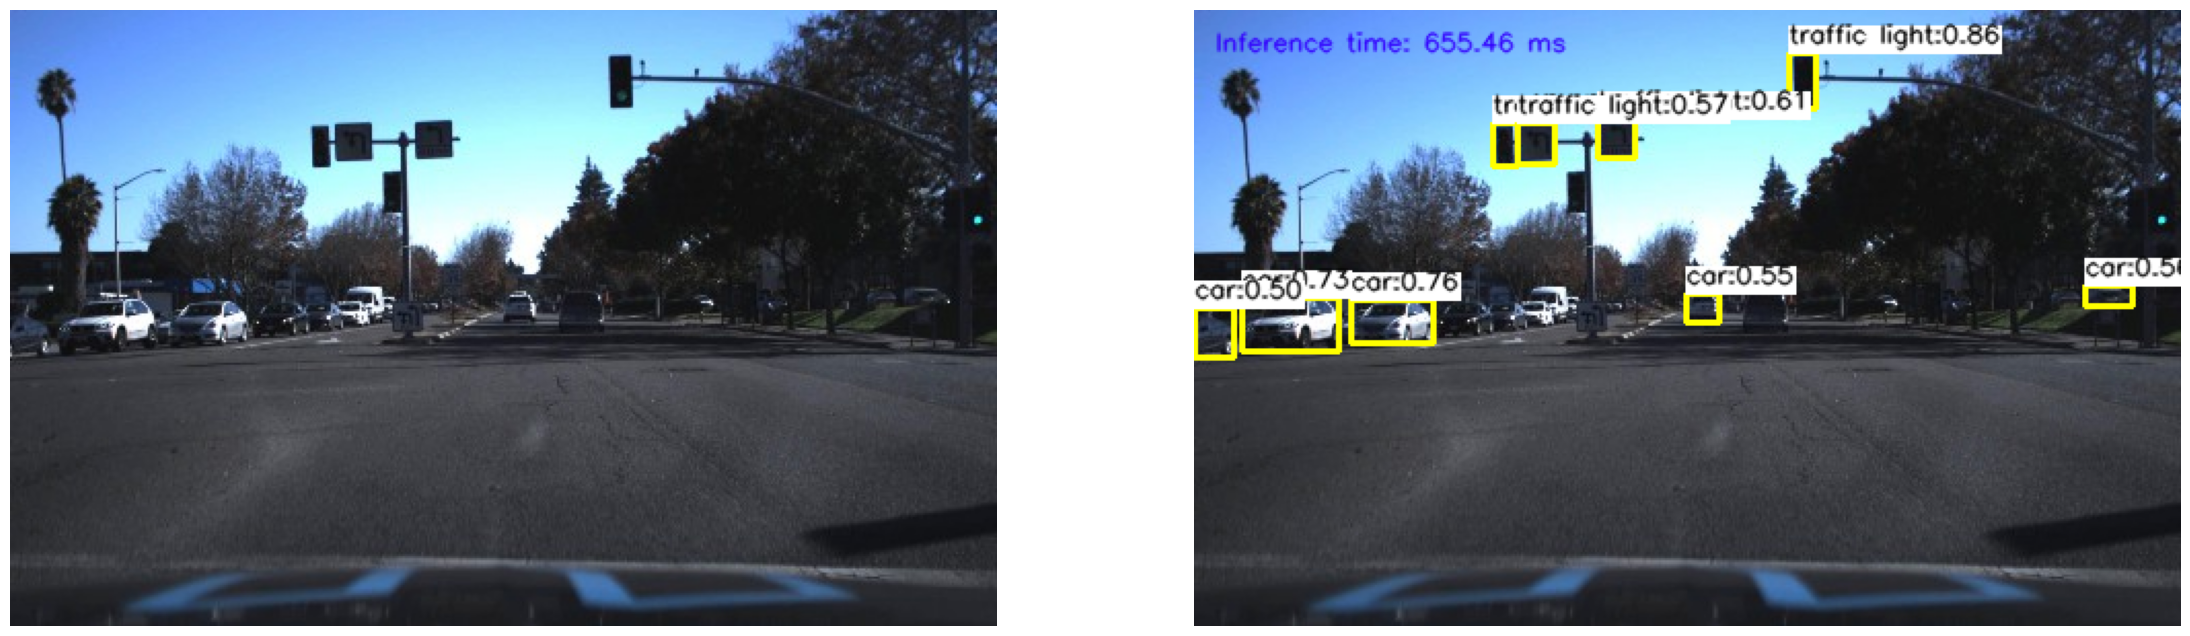

In [16]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


# Load class names.
classesFile = "/content/coco.names.txt"
classes = None

with open(classesFile, 'rt') as f:
      classes = f.read().rstrip('\n').split('\n')

# Load the model using cv2.dnn.readNet: Yolo V5 Nano Model
modelWeights = "/content/yolov5n.onnx"
net = cv2.dnn.readNet(modelWeights)

for image_path in sample_images:
  # Load image
  frame = cv2.imread(image_path)


  # Process image:
  detections = yolo_forward_pass(frame, net)
  pred_img = post_process_outputs(frame.copy(), detections)

  """
  Annotate efficiency information. The function getPerfProfile returns the overall time for inference(t)
  and the timings for each of the layers(in layersTimes).
  """
  t, _ = net.getPerfProfile()
  label = 'Inference time: %.2f ms' % (t * 1000.0 /  cv2.getTickFrequency())
  cv2.putText(pred_img, label, (10, 20), FONT_FACE, FONT_SCALE,  (255, 0, 50), THICKNESS, cv2.LINE_AA)
  
  fig = plt.figure(figsize=(28,16))
  ax1 = fig.add_subplot(1,2,1)
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB )
  ax1.imshow(frame)
  ax1.axis('off')


  ax2 = fig.add_subplot(1,2,2)
  pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB )
  ax2.imshow(pred_img)
  ax2.axis('off')
  
  plt.show()


In [17]:
#https://drive.google.com/file/d/1KyOIRWMBE-oX7em0bhTPkBbbM5mAlKII/view?usp=sharing
!gdown 1KyOIRWMBE-oX7em0bhTPkBbbM5mAlKII

Downloading...
From: https://drive.google.com/uc?id=1KyOIRWMBE-oX7em0bhTPkBbbM5mAlKII
To: /content/Vid_Self-Driving_Demo.mp4
100% 41.4M/41.4M [00:00<00:00, 53.9MB/s]


In [18]:
!ls

 coco.names.txt  'selfdriving cars data'       yolov5n.onnx
 __MACOSX	 'selfdriving cars data.zip'   YoloV5_ONNX.zip
 sample_data	  Vid_Self-Driving_Demo.mp4    yolov5s.onnx


In [19]:
import cv2

# path where video is stored
vid_path = 'Vid_Self-Driving_Demo.mp4'


In [20]:
def count_frames(video_path, manual=False):
  '''
  This function calculate total count of frames in video
  '''
  def manual_count(handler):
      frames = 0
      while True:
          status, frame = handler.read()
          if not status:
              break
          frames += 1
      return frames 

  stream = cv2.VideoCapture(video_path)
  if manual:
      frames = manual_count(stream)
  else:
      try:
          frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      except:
          frames = manual_count(cap)
  stream.release()
  return frames


frame_count = count_frames(vid_path, manual=True)
print("Total Frames: ", frame_count)

Total Frames:  2801


In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
from tqdm.auto import tqdm

stream = cv2.VideoCapture(vid_path)
ret, img_src = stream.read()

output = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),30 , (img_src.shape[1],img_src.shape[0]))


# Load class names.
classesFile = "/content/coco.names.txt"
classes = None

with open(classesFile, 'rt') as f:
      classes = f.read().rstrip('\n').split('\n')


# Load the model using cv2.dnn.readNet: Yolo V5 Small
modelWeights = "/content/yolov5s.onnx"
net = cv2.dnn.readNet(modelWeights)


# Initiate the progress bar
with tqdm(total=frame_count-1) as pbar:
  # start looping over video stream to extract frame and run inference
  while True:
      # Read frame from camera
      ret, image_np = stream.read()
      if not ret:
        break

      # Load image
      frame = cv2.imread(image_path)

      # Process image:
      detections = yolo_forward_pass(image_np, net)
      img = post_process_outputs(image_np.copy(), detections)

      """
      Annotate efficiency information. Method getPerfProfile of net object returns the overall time for inference(t)
      and the timings for each of the layers(in layersTimes).
      """
      t, _ = net.getPerfProfile()
      label = 'Inference time: %.2f ms' % (t * 1000.0 /  cv2.getTickFrequency())
      cv2.putText(img, label, (10, 20), FONT_FACE, FONT_SCALE,  (0, 255, 200), THICKNESS, cv2.LINE_AA)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      

      # Display output: Doesn't work in colab Environment: Uncomment to play the follwing video in standard environment
      #cv2.imshow( cv2.resize(image_np_with_detections, (800, 600)))
      output.write(img)

      # update the progress bar
      pbar.update(1)

      if cv2.waitKey(25) & 0xFF == ord('q'):
          break

  stream.release()
  output.release()
  cv2.destroyAllWindows()
  print("Processing Complete. Download and Play the Video File named 'Output.mp4' ")

  0%|          | 0/2800 [00:00<?, ?it/s]

In [ ]:
ls

In [ ]:
from google.colab import files
files.download('output.mp4') 